# NER with Bert

Source: https://medium.com/@andrewmarmon/fine-tuned-named-entity-recognition-with-hugging-face-bert-d51d4cb3d7b5

In [27]:
import os
import re
import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

In [2]:
label_list = ['O','B-MISC','I-MISC','B-PER','I-PER','B-ORG','I-ORG','B-LOC','I-LOC']
label_encoding_dict = {'I-PRG': 2,'I-I-MISC': 2, 'I-OR': 6,  'I-': 0, 'VMISC': 0, # line covers ann=tation erros in train file 
                       'O': 0, 'B-MISC': 1, 'I-MISC': 2, 'B-PER': 3, 'I-PER': 4, 'B-ORG': 5, 'I-ORG': 6, 'B-LOC': 7, 'I-LOC': 8,}

task = "ner" 
model_checkpoint = "distilbert-base-uncased"
batch_size = 16
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [3]:
def get_all_tokens_and_ner_tags(directory):
    return pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in os.listdir(directory)]).reset_index().drop('index', axis=1)
    
def get_tokens_and_ner_tags(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        split_list = [list(y) for x, y in itertools.groupby(lines, lambda z: z == '\n') if not x]
        tokens = [[x.split('\t')[0] for x in y] for y in split_list]
        entities = [[x.split('\t')[1][:-1] for x in y] for y in split_list] 
    return pd.DataFrame({'tokens': tokens, 'ner_tags': entities})
  
def get_un_token_dataset(train_directory, test_directory):
    train_df = get_all_tokens_and_ner_tags(train_directory)
    test_df = get_all_tokens_and_ner_tags(test_directory)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return (train_dataset, test_dataset)

In [4]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["tokens"]), truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label_encoding_dict[label[word_idx]])
            else:
                label_ids.append(label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [5]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[label_list[p] 
                         for (p, l) in zip(prediction, label) 
                         if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], 
            "recall": results["overall_recall"], "f1": results["overall_f1"], 
            "accuracy": results["overall_accuracy"]}

## Read annotated data

In [6]:
train_dataset, test_dataset = get_un_token_dataset('../../data/UN-named-entity-recognition/tagged-training/', 
                                                   '../../data/UN-named-entity-recognition/tagged-test/')

In [7]:
train_tokenized_datasets = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_and_align_labels, batched=True)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 19.07ba/s]


## Train model

In [8]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=1e-5,
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

In [9]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=test_tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()
trainer.save_model('un-ner.model')

The following columns in the training set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
/home/erikt/projects/rel20/venv3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3657
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 687


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.052608,0.789836,0.850255,0.818933,0.982015
2,No log,0.049980,0.830493,0.858600,0.844313,0.984916
3,0.063400,0.057054,0.828901,0.866945,0.847496,0.985039


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2074
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForTokenClassification.forward` and have been ignored: tokens, ner_tags. If tokens, ner_tags are not expected by `DistilBertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2074
  Batch size = 16
Saving model checkpoint to test-ner/checkpoint-500
Configuration saved in test-ner/checkpoint-500/config.json
Model weights saved in test-ner/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-ner/checkpoint-500/tokenizer_config.json
Special tokens file saved in t

Saving model checkpoint to un-ner.model
Configuration saved in un-ner.model/config.json
Model weights saved in un-ner.model/pytorch_model.bin
tokenizer config file saved in un-ner.model/tokenizer_config.json
Special tokens file saved in un-ner.model/special_tokens_map.json


## Test model

In [10]:
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')

paragraph = '''
    Before proceeding further, I should like to inform members that action on draft 
    resolution iv, entitled situation of human rights of Rohingya Muslims and other 
    minorities in Myanmar is postponed to a later date to allow time for the review 
    of its programme budget implications by the fifth committee. The assembly will 
    take action on draft resolution iv as soon as the report of the fifth committee 
    on the programme budget implications is available. I now give the floor to 
    delegations wishing to deliver explanations of vote or position before voting or 
    adoption.'''
tokens = tokenizer(paragraph)
torch.tensor(tokens['input_ids']).unsqueeze(0).size()

Didn't find file ./un-ner.model/added_tokens.json. We won't load it.
loading file ./un-ner.model/vocab.txt
loading file ./un-ner.model/tokenizer.json
loading file None
loading file ./un-ner.model/special_tokens_map.json
loading file ./un-ner.model/tokenizer_config.json


torch.Size([1, 103])

In [11]:
model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/', num_labels=len(label_list))
predictions = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
predictions = torch.argmax(predictions.logits.squeeze(), axis=1)
predictions = [label_list[i] for i in predictions]

loading configuration file ./un-ner.model/config.json
Model config DistilBertConfig {
  "_name_or_path": "./un-ner.model/",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "

In [12]:
words = tokenizer.batch_decode(tokens['input_ids'])
pd.DataFrame({'ner': predictions, 'words': words}).to_csv('un_ner.csv')

# bert large NER

Source: https://huggingface.co/dslim/bert-large-NER

In [6]:
import re
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

In [1]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-large-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-large-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

/home/erikt/projects/rel20/venv3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[{'entity': 'B-PER', 'score': 0.9971501, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.9986046, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


In [2]:
example = "SOCCER - GERMAN FIRST DIVISION SUMMARIES. BONN 1996-12-06 Summaries of matches played in the German first division on Friday : Bochum 2 (Stickroth 30th pen, Wosz 89th) Bayer Leverkusen 2 (Kirsten 18th, Ramelow 56th). Halftime 1-1. Attendance : 24,602 Werder Bremen 1 (Bode 85th) 1860 Munich 1 (Bormirow 8th). Halftime 0-1. Attendance 33,000 Karlsruhe 3 (Reich 29th, Carl 44th, Dundee 69th) Freiburg 0. Halftime 2-0. Attendance 33,000 Schalke 2 (Mulder 2nd and 27th) Hansa Rostock 0. Halftime 2-0. Attendance 29,300"

In [16]:
tokenizer.tokenize(example)[:17]

['S',
 '##OC',
 '##CE',
 '##R',
 '-',
 'GE',
 '##R',
 '##MA',
 '##N',
 'F',
 '##IR',
 '##ST',
 'D',
 '##I',
 '##VI',
 '##SI',
 '##ON']

In [20]:
counter = 0
for word in tokenizer.tokenize("Soccer - Italian First Division Matches This Weekend. Rome 1996-12-06 Italian Serie A games to be played on Sunday ( league positions in parentheses , all kick- off times Gmt ) : Bologna ( 4 ) v Piacenza ( 13 ) 1330 Along with leaders Vicenza , fourth-placed Bologna represent the biggest surprise of this Italian autumn. Led as usual by Swede Kennet Andersson and Russian Igor Kolyvanov in attack , Bologna can expect a tough home match against a Piacenza side still exultant after a 3-2 league win over Ac Milan last Sunday. Cagliari ( 16 ) v Reggiana ( 18 ) 1530 Cagliari start favourite in this relegation scrap following draws with Napoli and Inter in last two outings but will be without suspended iSwiss defender Ramon Vega. Bottom team Reggiana are also without a suspended defender , German Dietmar Beiersdorfer. Fiorentina ( 10 ) v Perugia ( 8 ) 1330 Fiorentina will be without three suspended players – defenders Daniele Carnasciali and Lorenzo Amoruso and midfielder Emiliano Bigica – for a difficult home match against unpredictable , attack-oriented Perugia led by in-form Croat striker Milan Rapajic and the experienced Fausto Pizzi. Lazio ( 12 ) v As Roma ( 7 ) 1930 Poor man ’s Roman derby in what has been a miserable season for both Rome teams , already eliminated from the Italian and Uefa Cups. Lazio have injury doubts about striker Pierluigi Casiraghi , Czech midfielder Pavel Nedved and defender Paolo Negro , while Roma present a full strength side led by Argentine Abel Balbo , Marco Delvecchio and Francesco Totti in attack. Ac Milan ( 9 ) v Udinese ( 11 ) 1330 Can Milan sink any further ? Following their midweek Champions ’ League elimination by Norwegian side Rosenborg , a morale-boosting win is badly needed. Liberian striker George Weah makes a welcome return for Milan alongside Roberto Baggio , with Montenegrin Dejan Savicevic in midfield. Good news for Milan is that Udinese ’s German striker Oliver Bierhoff is out through injury. Napoli ( 5 ) v Verona ( 17 ) 1330 In-form Napoli should prove too strong for second from bottom Verona despite the absence of their suspended Argentine defender Roberto Ayala. Verona ’s slim chances have been further reduced by a knee injury to their experienced midfielder Eugenio"):
    counter += 1
    print(counter, word)

1 Soccer
2 -
3 Italian
4 First
5 Division
6 Matches
7 This
8 Weekend
9 .
10 Rome
11 1996
12 -
13 12
14 -
15 06
16 Italian
17 Serie
18 A
19 games
20 to
21 be
22 played
23 on
24 Sunday
25 (
26 league
27 positions
28 in
29 parent
30 ##heses
31 ,
32 all
33 kick
34 -
35 off
36 times
37 G
38 ##m
39 ##t
40 )
41 :
42 Bologna
43 (
44 4
45 )
46 v
47 Pi
48 ##ace
49 ##nza
50 (
51 13
52 )
53 133
54 ##0
55 Along
56 with
57 leaders
58 Vice
59 ##nza
60 ,
61 fourth
62 -
63 placed
64 Bologna
65 represent
66 the
67 biggest
68 surprise
69 of
70 this
71 Italian
72 autumn
73 .
74 Led
75 as
76 usual
77 by
78 S
79 ##wed
80 ##e
81 Ken
82 ##net
83 Anders
84 ##son
85 and
86 Russian
87 Igor
88 Ko
89 ##ly
90 ##van
91 ##ov
92 in
93 attack
94 ,
95 Bologna
96 can
97 expect
98 a
99 tough
100 home
101 match
102 against
103 a
104 Pi
105 ##ace
106 ##nza
107 side
108 still
109 ex
110 ##ult
111 ##ant
112 after
113 a
114 3
115 -
116 2
117 league
118 win
119 over
120 A
121 ##c
122 Milan
123 last
124 Sunday
125 .
126 C
127 ##

In [3]:
ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-MISC', 'score': 0.99924064, 'index': 6, 'word': 'GE', 'start': 9, 'end': 11}, {'entity': 'I-MISC', 'score': 0.8793608, 'index': 7, 'word': '##R', 'start': 11, 'end': 12}, {'entity': 'I-MISC', 'score': 0.884922, 'index': 8, 'word': '##MA', 'start': 12, 'end': 14}, {'entity': 'I-MISC', 'score': 0.9773442, 'index': 9, 'word': '##N', 'start': 14, 'end': 15}, {'entity': 'B-MISC', 'score': 0.9992536, 'index': 40, 'word': 'German', 'start': 93, 'end': 99}, {'entity': 'B-ORG', 'score': 0.9987205, 'index': 46, 'word': 'Bo', 'start': 127, 'end': 129}, {'entity': 'I-ORG', 'score': 0.99158394, 'index': 47, 'word': '##chu', 'start': 129, 'end': 132}, {'entity': 'I-ORG', 'score': 0.9947837, 'index': 48, 'word': '##m', 'start': 132, 'end': 133}, {'entity': 'B-PER', 'score': 0.998579, 'index': 51, 'word': 'Stick', 'start': 137, 'end': 142}, {'entity': 'B-PER', 'score': 0.44963565, 'index': 52, 'word': '##roth', 'start': 142, 'end': 146}, {'entity': 'B-PER', 'score': 0.9985172, 'index': 

In [4]:
def combine_entities(ner_results):
    ner_results_out = []
    i = 0
    while i < len(ner_results)-1:
        last_end = ner_results[i]["end"]
        ner_results_out.append(dict(ner_results[i]))
        j = 1
        while i + j < len(ner_results) and (ner_results[i+j]["start"] == last_end or
                                            (ner_results[i+j]["start"] == last_end + 1 and 
                                             re.search("^I", ner_results[i+j]["entity"]) and
                                             re.sub("^..", "", ner_results[i+j]["entity"]) == re.sub("^..", "", ner_results[i]["entity"]))):
            if ner_results[i+j]["start"] == last_end:
                ner_results_out[-1]["word"] += re.sub("^##", "", ner_results[i+j]["word"])
            else:
                ner_results_out[-1]["word"] += " " + ner_results[i+j]["word"]
            ner_results_out[-1]["end"] = ner_results[i+j]["end"]
            last_end = ner_results[i+j]["end"]
            j += 1
        i += j
    return ner_results_out

In [7]:
combine_entities(ner_results)

[{'entity': 'B-MISC',
  'score': 0.99924064,
  'index': 6,
  'word': 'GERMAN',
  'start': 9,
  'end': 15},
 {'entity': 'B-MISC',
  'score': 0.9992536,
  'index': 40,
  'word': 'German',
  'start': 93,
  'end': 99},
 {'entity': 'B-ORG',
  'score': 0.9987205,
  'index': 46,
  'word': 'Bochum',
  'start': 127,
  'end': 133},
 {'entity': 'B-PER',
  'score': 0.998579,
  'index': 51,
  'word': 'Stickroth',
  'start': 137,
  'end': 146},
 {'entity': 'B-PER',
  'score': 0.9985172,
  'index': 56,
  'word': 'Wosz',
  'start': 157,
  'end': 161},
 {'entity': 'B-ORG',
  'score': 0.99935025,
  'index': 62,
  'word': 'Bayer Leverkusen',
  'start': 168,
  'end': 184},
 {'entity': 'B-PER',
  'score': 0.99836916,
  'index': 70,
  'word': 'Kirsten',
  'start': 188,
  'end': 195},
 {'entity': 'B-PER',
  'score': 0.9985753,
  'index': 74,
  'word': 'Ramelow',
  'start': 202,
  'end': 209},
 {'entity': 'B-ORG',
  'score': 0.99929786,
  'index': 93,
  'word': 'Werder Bremen',
  'start': 251,
  'end': 264},


## Performance graph for different document sizes

In [1]:
from matplotlib import pyplot as plt

In [2]:
x_base  = [   50,   75,  100,  125,  150,  175,  200,  300,  400 ]
y_base  = [ 70.3, 71.7, 71.7, 71.7, 72.1, 71.7, 71.5, 71.2, 68.5 ]
x_large = [              100, 125,  150,  175,  200,  300 ]
y_large = [             73.3, 73.8, 73.8, 74.2, 74.1, 73.5 ]

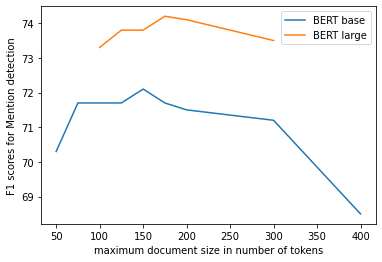

In [3]:
plt.plot( x_base,  y_base, label="BERT base")
plt.plot(x_large, y_large, label="BERT large")
plt.xlabel("maximum document size in number of tokens")
plt.ylabel("F1 scores for Mention detection")
plt.legend()
plt.savefig("f1.png")
plt.show()

## Accessing the BERT tokenizer

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

/home/erikt/projects/rel20/venv3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_or_url = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(path_or_url)
model = AutoModelForTokenClassification.from_pretrained(path_or_url)
ner_tagger = pipeline("ner", model=model, tokenizer=tokenizer)

In [21]:
for token_id in ner_tagger.tokenizer(["John saw Mary in Groningen."])["input_ids"][0]:
    print(ner_tagger.tokenizer.decode(token_id))

[CLS]
John
saw
Mary
in
G
##ron
##ingen
.
[SEP]
